<a href="https://colab.research.google.com/github/jahangeer91/projects/blob/main/PowerConsumptionPOC_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

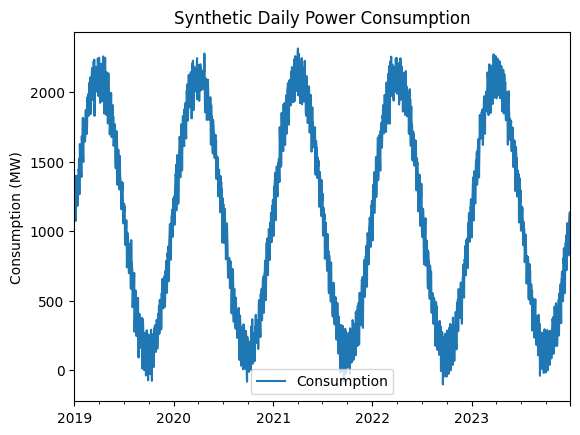

            Consumption
2019-01-01  1242.049064
2019-01-02  1227.508397
2019-01-03  1284.004094
2019-01-04  1344.953920
2019-01-05  1074.257130


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Define the time period
num_days = 365 * 5  # Five years of daily data
index = pd.date_range(start='2019-01-01', periods=num_days, freq='D')

# Generate seasonal effect using a sine wave
annual_effect = 1000 * np.sin(2 * np.pi * index.dayofyear / 365)

# Weekly pattern: weekends have lower consumption
weekly_effect = -200 * index.weekday.isin([5, 6])

# Base daily consumption and noise
daily_consumption = np.random.normal(loc=1200, scale=50, size=num_days)

# Total consumption
total_consumption = daily_consumption + annual_effect + weekly_effect

# Create DataFrame
data = pd.DataFrame(data={'Consumption': total_consumption}, index=index)

# Plot the data
data.plot(title='Synthetic Daily Power Consumption')
plt.ylabel('Consumption (MW)')
plt.show()

# Display first few rows
print(data.head())


Step 1: Exploratory Data Analysis

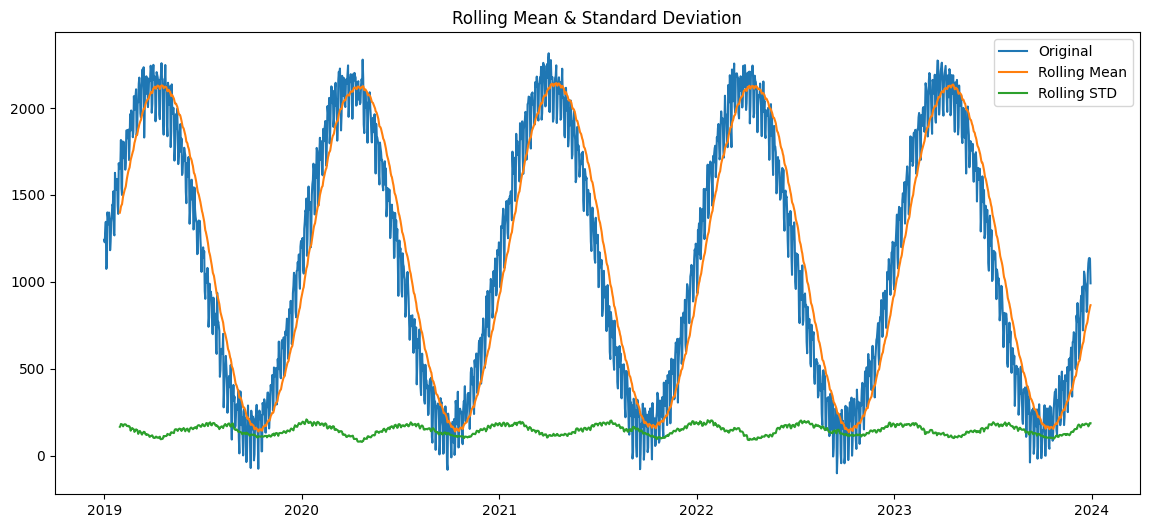

In [ ]:
# Plotting rolling statistics
data['Rolling_Mean'] = data['Consumption'].rolling(window=30).mean()
data['Rolling_STD'] = data['Consumption'].rolling(window=30).std()

plt.figure(figsize=(14, 6))
plt.plot(data['Consumption'], label='Original')
plt.plot(data['Rolling_Mean'], label='Rolling Mean')
plt.plot(data['Rolling_STD'], label='Rolling STD')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()


Step 2: Model Building - SARIMA Model Identification

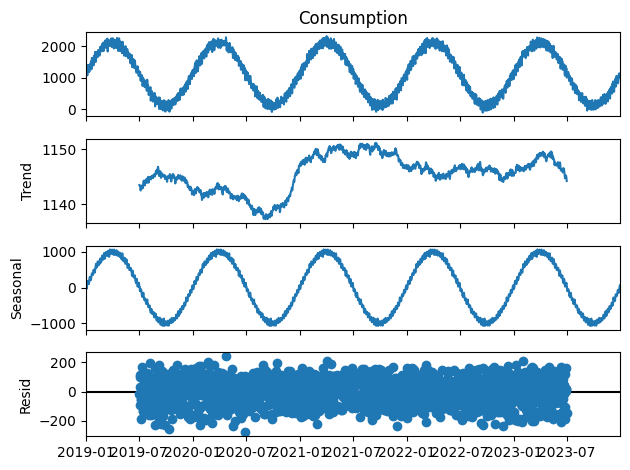

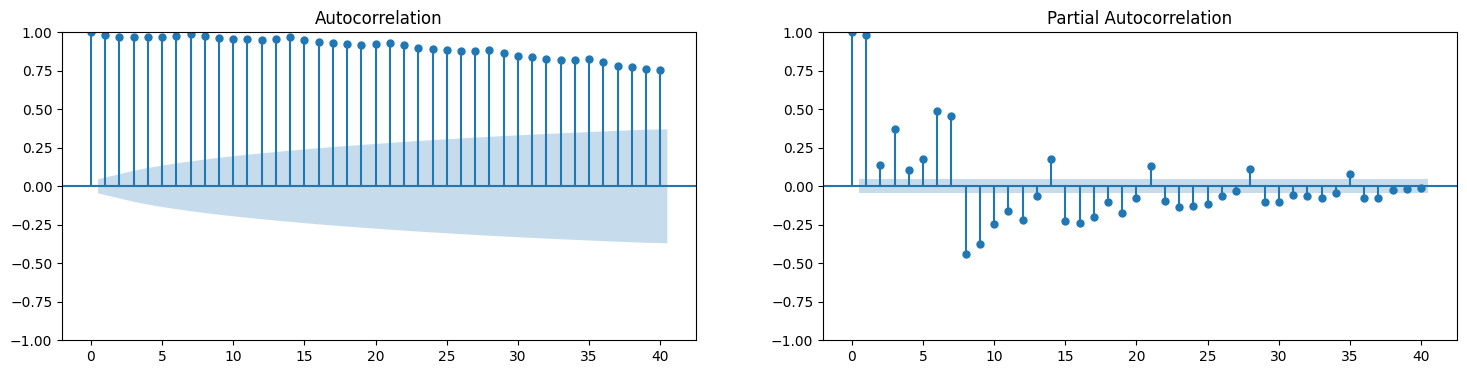

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# Decompose the time series
decomposition = seasonal_decompose(data['Consumption'], model='additive', period=365)
fig = decomposition.plot()
plt.show()

# Autocorrelation and Partial Autocorrelation Plots
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
plot_acf(data['Consumption'], ax=ax[0], lags=40)
plot_pacf(data['Consumption'], ax=ax[1], lags=40)
plt.show()


Step 3: Model Fitting and Forecasting

Optimization terminated successfully.
         Current function value: 6.127715
         Iterations: 7
         Function evaluations: 374


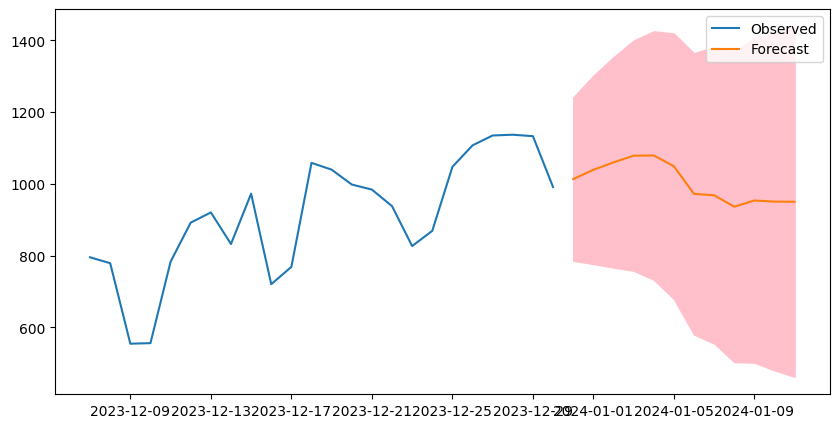

In [ ]:
#import matplotlib.pyplot as plt

# Fit a simplified SARIMA model
model = sm.tsa.statespace.SARIMAX(data['Consumption'],
                                  order=(1, 0, 1),              # Slightly simpler non-seasonal parameters
                                  seasonal_order=(1, 0, 1, 12), # Using monthly seasonality for demonstration
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

# Use the 'powell' method to speed up convergence
results = model.fit(method='powell')

# Forecasting
forecast = results.get_forecast(steps=12)  # Forecast the next year (12 months, not 365 days)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(data.index[-2 * 12:], data['Consumption'][-2 * 12:], label='Observed')  # Plot the last 24 months for context
plt.plot(mean_forecast.index, mean_forecast, label='Forecast')
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink')
plt.legend()
plt.show()


Step 4: Model Evaluation

In [ ]:
# Calculate and print the evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming `actuals` holds the true values for the days we forecasted:
actuals = data['Consumption'][-12:]  # This would be replaced with actual observed values in a real scenario
mae = mean_absolute_error(actuals, mean_forecast)
rmse = mean_squared_error(actuals, mean_forecast, squared=False)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 127.99354330654114
RMSE: 146.3777745993392
